In [ ]:
!pip install sympy SumOfSquares

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
import scipy.integrate, scipy.linalg, scipy.optimize
from SumOfSquares import SOSProblem

The time-reversed van der Pol oscillator is governed by

$$
\begin{align*}
  \dot{x}_1 &= -x_2 ,  \\
  \dot{x}_2 &= x_1 + (x_1^2 - 1) x_2 .
\end{align*}
$$

In [2]:
def time_reversed_vanderpol_dynamics(x):
    from copy import deepcopy
    x_dot = deepcopy(x)
    x_dot[0] = -x[1]
    x_dot[1] = x[0] + (x[0]**2 - 1) * x[1]
    return x_dot

The following code block plots the phase portrait of the system.

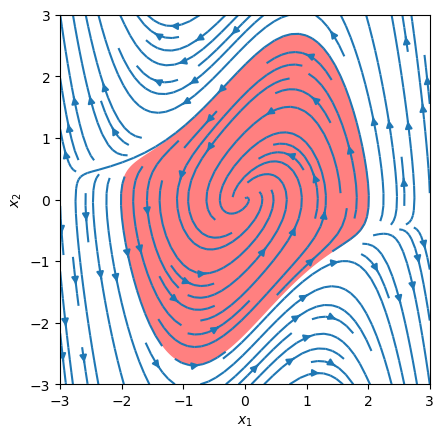

In [3]:
def vanderpol_limit_cycle():
    sol = scipy.integrate.solve_ivp(
        lambda t,x: -time_reversed_vanderpol_dynamics(x),
        t_span=[0,20],
        y0=[2.01989138,0],
        max_step=1e-2,
        events=lambda t,x: x[1]
    )
    t_start, t_end = sol.t_events[0][-3], sol.t_events[0][-1]
    mask = np.logical_and(t_start <= sol.t, sol.t <= t_end)
    x1, x2 = sol.y[0,mask], sol.y[1,mask]
    return x1, x2

plt.fill(*vanderpol_limit_cycle(), color=[1,0.5,0.5])

x1 = np.linspace(-3, 3, 101)
x2 = np.linspace(-3, 3, 101)
x1, x2 = np.meshgrid(x1, x2)
x = np.stack((x1,x2))
x_dot = time_reversed_vanderpol_dynamics(x)
plt.streamplot(x[0], x[1], x_dot[0], x_dot[1])

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.axis('square')
plt.show()

### Finding region of attraction using a Lyapunov function obtained from linearization

The linearization of the system at the origin gives

$$
\begin{bmatrix} \dot{x}_1 \\ \dot{x}_2 \end{bmatrix} =
\underbrace{\begin{bmatrix} 0 & -1 \\ 1 & -1 \end{bmatrix}}_{\mathbf{A}}
\begin{bmatrix} x_1 \\ x_2 \end{bmatrix} .
$$

Solving the Lyapunov equation $\mathbf{A}^\top \mathbf{P} + \mathbf{P} \mathbf{A} = -\mathbf{I}$ gives us  a Lyapunov function $V(\boldsymbol{x}) = \boldsymbol{x}^\top \mathbf{P} \boldsymbol{x}$.

The region of attraction is found be solving the following SOS optimization problem:

$$
\begin{align*}
  & \text{maximize}   && \rho  \\
  & \text{subject to} && (\boldsymbol{x}^\top \boldsymbol{x})^d (V(\boldsymbol{x}) - \rho) + \lambda(\boldsymbol{x}) \dot{V}(\boldsymbol{x}) \text{ is SOS} .
\end{align*}
$$

What degree should we choose for $\lambda(\boldsymbol{x})$ here? $V(\boldsymbol{x})$ has degree 2, $\dot{V}(\boldsymbol{x})$ has degree 4, $(\boldsymbol{x}^\top \boldsymbol{x})$ has degree 2. By choosing $d=1$, a zero-degree $\lambda(\boldsymbol{x})$ is sufficient here.

In [5]:
def freePolynomial(vars, degrees) -> sp.Expr:
    from itertools import combinations_with_replacement
    if not hasattr(freePolynomial, 'i'):
        freePolynomial.i = 0
    poly = sp.S(0)
    for degree in range(0, degrees+1):
        for comb in combinations_with_replacement(vars, degree):
            if degree == 0:
                comb = [sp.S(1)]
            freePolynomial.i += 1
            poly += sp.symbols(f'c_{freePolynomial.i}', real=True) * sp.prod(comb)
    return poly


A = np.mat('0 -1; 1 -1') # linearization of time_reversed_vanderpol_dynamics
P = scipy.linalg.solve_continuous_lyapunov(A.T, -np.diag([1,2])) # A.T @ P + P @ A = -diag([1 2])

x1, x2 = sp.symbols('x_1 x_2')
x = sp.Matrix([x1, x2])
x_dot = time_reversed_vanderpol_dynamics(x)

V = (x.T @ P).dot(x)
V_dot = 2 * (x.T @ P).dot(x_dot)

rho = sp.symbols(r'\rho')

_lambda = freePolynomial(x, 0)

prob = SOSProblem()
prob.add_sos_constraint(x.dot(x) * (V - rho) + _lambda * V_dot, [x1,x2])
prob.set_objective('max', prob.sym_to_var(rho))

prob.solve(solver='cvxopt')
rho = prob.sym_to_var(rho).value

print("Status: ", prob.status)
print("rho: ", rho)

Status:  optimal
rho:  2.23621059074153


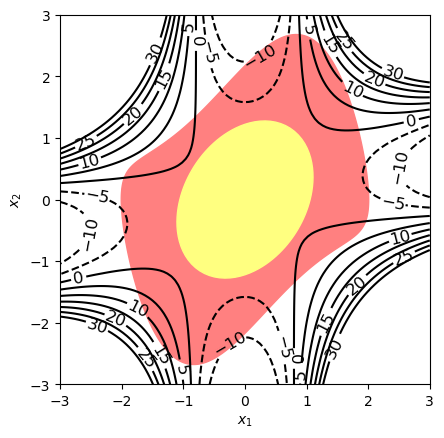

In [6]:
def sublevel_set(U, num_points=101):
    """returns the boundary of the sublevel set where U(x1,x2) <= 1
    """
    theta = np.linspace(0, 2*np.pi, num_points)
    r = np.zeros_like(theta)
    for i in range(len(theta)-1):
        f = lambda r: U(r*np.cos(theta[i]), r*np.sin(theta[i])) - 1
        r[i] = scipy.optimize.root_scalar(f, method='bisect', bracket=[0.0,100.0]).root
    r[-1] = r[0]
    return r * np.cos(theta), r * np.sin(theta)

plt.fill(*vanderpol_limit_cycle(), color=[1,0.5,0.5])

plt.fill(*sublevel_set(sp.lambdify([x1,x2],V/rho)), color=[1,1,0.5])

x1_val = np.linspace(-3, 3, 101)
x2_val = np.linspace(-3, 3, 101)
x1_val, x2_val = np.meshgrid(x1_val, x2_val)
V_dot_val = sp.lambdify([x1,x2], V_dot, 'numpy')(x1_val, x2_val)
cs = plt.contour(x1_val, x2_val, V_dot_val, levels=np.arange(-10,35,5), colors='k')
plt.gca().clabel(cs, fontsize=12)

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.axis('square')
plt.show()